# Beyond Principal component analysis
## t-distributed stochastic neighbor embedding (tSNE)

### Term project for Linear Algebra - M1 - 2019 - JVN Institute

Students:  
- Nguyen The Phong
- Do Thi Huong Trang  
- Nguyen Minh Thu  
- Le Thien Toan

In [1]:
from time import time
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib import offsetbox

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn import manifold, datasets, decomposition, random_projection
from sklearn.cluster import KMeans

from utility import *
from tsne import tsne as tsne_impl

## I. t-SNE theory:  

### 1. Introduction:
Visualization can be very helpful in studying the data. But it can only be done for low dimension (less than 4).  
t-SNE is one of many techniques that try to solve the problem of visualizing high dimensional data.  
The visualization of t-SNE can reveal structure of data. Furthermore, t-SNE's result is shown to be better than others.  
Original paper by Geoffrey Hinton and Laurens van der Maaten: [pdf](https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf)  

For demonstration purpose, MNIST Dataset will be used (http://yann.lecun.com/exdb/mnist)  
Please note that, t-SNE is an unsupervised machine learning method. The label is only used for color in visualizations.

In [2]:
# Load MNIST digits dataset
digits = datasets.load_digits()
X = digits.data
y = digits.target
n_samples, n_features = X.shape
print('X shape: (%s, %s)' % (n_samples, n_features))

X shape: (1797, 64)


Text(0.5, 1.0, 'A selection from the 64-dimensional digits dataset')

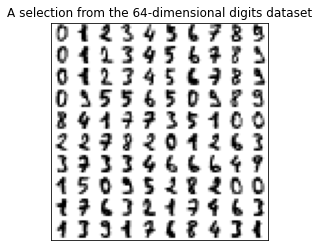

In [3]:
# Show some sample data
n_img_per_row = 10
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimensional digits dataset')

Each data point is a image with 8x8 pixels. We can treat MNIST as a 64 dimension dataset.  
Below we try to randomly project the dataset into 2 dimensional space.  
Not much information can be drawn from the visual.  
Now let's see how t-SNE performs on visualizing MNIST.

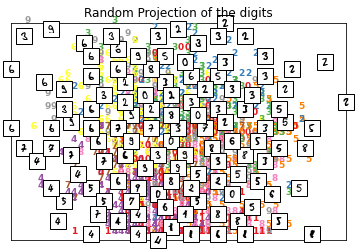

In [4]:
rp = random_projection.SparseRandomProjection(n_components=2, random_state=42)
X_projected = rp.fit_transform(X)
plot_embedding_MNIST(X_projected, y, digits, "Random Projection of the digits")

### 2. t-SNE:

t-SNE is a non-parametric model that try to visualize high dimensional data into two or three dimensional map.  
Based on Euclidian distance, t-SNE measures similarity between datapoints by using conditional probabilities:  
- pairwise similarity between datapoint i and j in high dimensional space $p_{ij}$:  
$$p_{ij} = \frac{exp(-||x_i - x_j||^2 / 2\sigma^2)}{\sum_{k \ne l} exp(-||x_k - x_l||^2 / 2\sigma^2)}$$
- pairwise similarity between datapoint i and j in low dimensional space $q_{ij}$:  
$$q_{ij} = \frac{(1 + ||y_i - y_j||^2)^{-1}}{\sum_{k \ne l} (1 + ||y_k - y_l||^2)^{-1}}$$

t-SNE finds the projection Y (low dimension) of X (high dimension) by doing Gradient Descent:  
- The cost function (sum of the Kullback-Leibler divergences):  
$$C = KL(P||Q) = \sum_i\sum_j p_{ij} log\frac{p_{ij}}{q_{ij}}$$
- Step:  
$$\frac{\partial C}{\partial y_i} = 4 \sum_j (p_{ij} - q_{ij})(y_i - y_j)(1 + ||y_i - y_j||^2)^{-1}$$
- Update:
$$Y^{(t)} = Y^{(t-1)} + \eta\frac{\partial C}{\partial Y} + \alpha(t)(Y^{(t-1)} - Y^{(t-2)})$$

Looking at the cost function:   
- When $p_{ij}$ is large but $q_{ij}$ is small, $x_i$ and $x_j$ is similar in high dimension but now dissimilar in low dimension, the cost will be high.   
- But when $p_{ij}$ is small but $q_{ij}$ is large, $x_i$ and $x_j$ is dissimilar in high dimension but now similar in low dimension, the cost will be low.  

We can see that t-SNE aims to retain the local structure (neighborhood distance) of similar points, while pay little attention to the global structure.

In [5]:
print("Computing t-SNE embedding")
n_neighbors = 30
t0 = time()
X_tsne_org, steps = tsne_impl(X, no_dims=2, perplexity=n_neighbors, return_steps=True, max_iter=1000)
tsne_time_org = time() - t0
tsne_plot_title_org = "t-SNE embedding of the digits (time %.2fs)" % (tsne_time_org)
print("Computing t-SNE embedding done (time %.2fs)" % (tsne_time_org))

Computing t-SNE embedding
Calculate perplexity for point 0 of 1797
Calculate perplexity for point 200 of 1797
Calculate perplexity for point 400 of 1797
Calculate perplexity for point 600 of 1797
Calculate perplexity for point 800 of 1797
Calculate perplexity for point 1000 of 1797
Calculate perplexity for point 1200 of 1797
Calculate perplexity for point 1400 of 1797
Calculate perplexity for point 1600 of 1797
[t-SNE] Mean sigma: 1.631640
Compute joint probability done!
Preprocessed with PCA done
Iteration 50 of 250
Iteration 100 of 250
Iteration 150 of 250
Iteration 200 of 250
Iteration 250 of 250
Iteration 300 of 1000
Iteration 350 of 1000
Iteration 400 of 1000
Iteration 450 of 1000
Iteration 500 of 1000
Iteration 550 of 1000
Iteration 600 of 1000
Iteration 650 of 1000
Iteration 700 of 1000
Iteration 750 of 1000
Iteration 800 of 1000
Iteration 850 of 1000
Iteration 900 of 1000
Iteration 950 of 1000
Iteration 1000 of 1000
Computing t-SNE embedding done (time 620.11s)


In [6]:
steps_data = np.array(steps)
steps_data = pd.DataFrame(data={'step': steps_data[:,0], 
                                'X1': steps_data[:,1], 
                                'X2': steps_data[:,2], 
                                'y':np.array([y]*(np.int(len(steps) / len(X)))).flatten()})
px.scatter(steps_data, x="X1", y="X2", animation_frame="step", color="y", hover_name="y", 
           range_x=[np.min(X_tsne_org[:,0]),np.max(np.max(X_tsne_org[:, 0]))], 
           range_y=[np.min(X_tsne_org[:,1]),np.max(np.max(X_tsne_org[:, 1]))])

Sklearn package also provide out-of-the-box implementation of t-SNE

In [7]:
n_neighbors = 30
tsne = manifold.TSNE(n_components=2, init='random', perplexity=n_neighbors, method='exact', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X)
tsne_time = time() - t0
tsne_plot_title = "t-SNE embedding of the digits (time %.2fs)" % (tsne_time)
print("Computing t-SNE embedding done (time %.2fs)" % (tsne_time))

Computing t-SNE embedding done (time 106.97s)


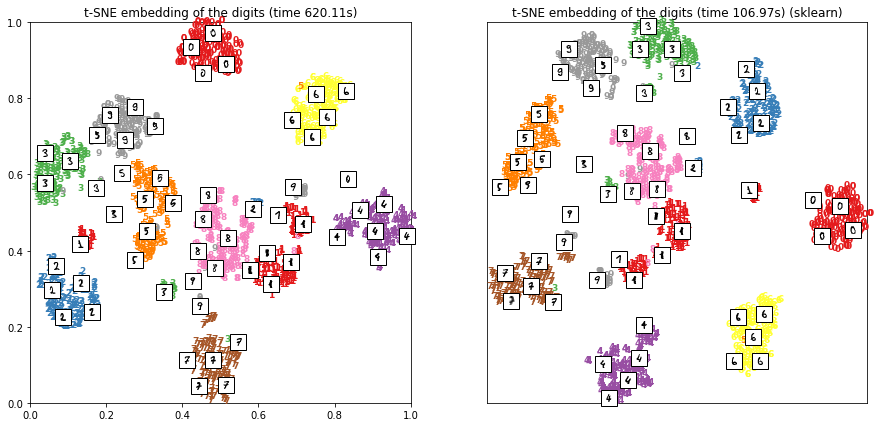

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15,7))

plot_embedding_MNIST(X_tsne_org, y, digits, tsne_plot_title_org, axes[0])

plot_embedding_MNIST(X_tsne, y, digits, tsne_plot_title + " (sklearn)", axes[1])

So by using t-SNE, we can visualize a high dimension (64) dataset into low dimension (2) map, which human can interprete.  
And by checking the map, we can see the dataset has some structure in form of clusters.

### 3. Compare with other techniques:

In this section, we will compare t-SNE with other three techniques (Principle Components Analysis, Spectral Embedding, and Isomap).  
We will see that the visualization of t-SNE is better than all in term of revealing the structure of data.

In [9]:
pca = decomposition.PCA(n_components=2)
t0 = time()
X_pca = pca.fit_transform(X)
pca_time = time() - t0
pca_plot_title = "Principal Components projection of the digits (time %.2fs)" % (pca_time)
print("Computing PCA projection done (time %.2fs)" % (pca_time))

Computing PCA projection done (time 0.01s)


In [10]:
embedder = manifold.SpectralEmbedding(n_components=2, random_state=0, eigen_solver="arpack")
t0 = time()
X_se = embedder.fit_transform(X)
se_time = time() - t0
se_plot_title = "Spectral embedding of the digits (time %.2fs)" % (se_time)
print("Computing Spectral embedding done (time %.2fs)" % (pca_time))

Computing Spectral embedding done (time 0.01s)


In [11]:
n_neighbors = 30
isom = manifold.Isomap(n_neighbors, n_components=2)
t0 = time()
X_isom = isom.fit_transform(X)
isom_time = time() - t0
isom_plot_title = "Isomap embedding of the digits (time %.2fs)" % (isom_time)
print("Computing Isomap embedding done (time %.2fs)" % (isom_time))

Computing Isomap embedding done (time 3.29s)


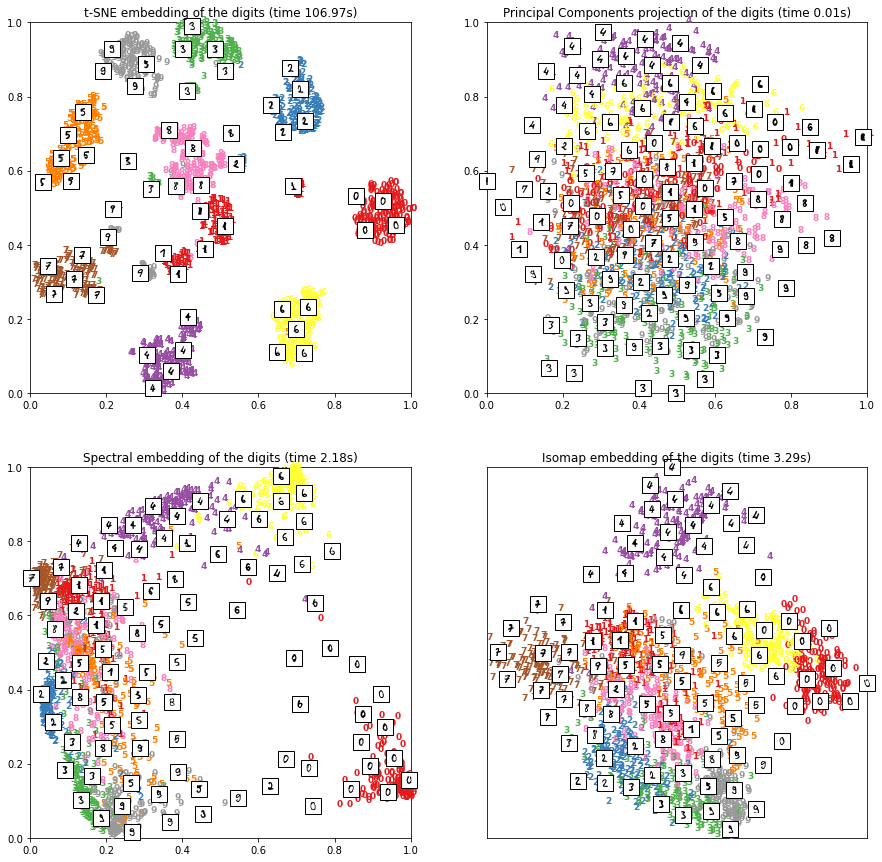

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(15,15))

plot_embedding_MNIST(X_tsne, y, digits, tsne_plot_title, axes[0][0])

plot_embedding_MNIST(X_pca, y, digits, pca_plot_title, axes[0][1])

plot_embedding_MNIST(X_se, y, digits, se_plot_title, axes[1][0])

plot_embedding_MNIST(X_isom, y, digits, isom_plot_title, axes[1][1])

## II. t-SNE in practice:

### 1. Scallability with Barnes-Hut approximation:

One problem of t-SNE is scalability.  
Each step of the the gradient descent includes computing the pairwise conditional probabilities of datapoints (O($N^2$)).  

In a more recent paper by Laurens van der Maaten: [Accelerating t-SNE](https://lvdmaaten.github.io/publications/papers/JMLR_2014.pdf)  
He proposed a solution for this problem by using an approcimation based on the Barnes-Hut algorithm. This approach reduces the gradient descent step significantly (O($NlogN$))

Computing faster t-SNE embedding


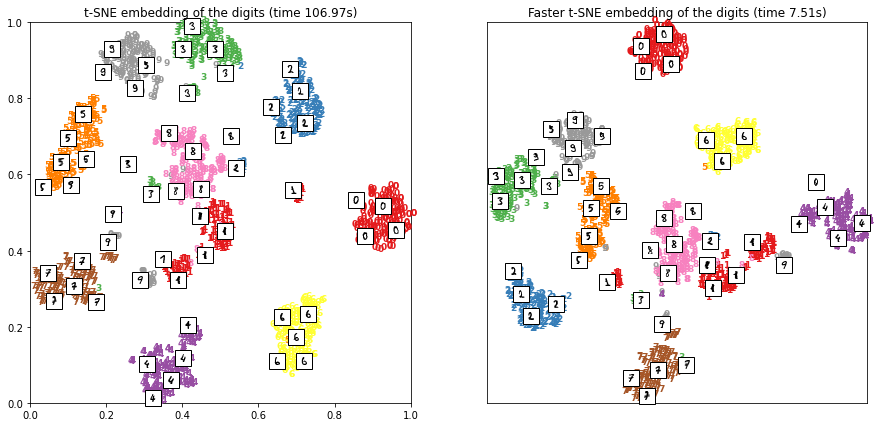

In [13]:
print("Computing faster t-SNE embedding")
n_neighbors = 30
tsne = manifold.TSNE(n_components=2, init='pca', perplexity=n_neighbors, method='barnes_hut', random_state=0)
t0 = time()
X_tsne_fast = tsne.fit_transform(X)
tsne_fast_time = time() - t0
tsne_fast_plot_title = "Faster t-SNE embedding of the digits (time %.2fs)" % (tsne_fast_time)

fig, axes = plt.subplots(1, 2, figsize=(15,7))
plot_embedding_MNIST(X_tsne, y, digits, tsne_plot_title, axes[0])
plot_embedding_MNIST(X_tsne_fast, y, digits, tsne_fast_plot_title, axes[1])

### 2. Parameters tuning:

There are two parameters:  
- Number of iteration (recommended at least 250)
- Perplexity (recommended from 5 to 50)

There is no instruction on how to choose these parameters for any specific dataset.  
Furthermore, part of t-SNE is based on random walk, so it is non deterministic.  
It is recommended that we plot the t-SNE map with several pair of parameters, and choose the one that look good.

In [14]:
perplexities = [2, 5, 30, 50, 100]
n_iters = [250, 1000, 5000]

X_tsne_list = []
tsne_title_list = []

for i in range(len(perplexities)):
    for j in range(len(n_iters)):
        tsne_temp = manifold.TSNE(n_components=2, init='pca', n_iter=n_iters[j], perplexity=perplexities[i], method='barnes_hut', random_state=0)
        t0 = time()
        X_tsne_temp = tsne_temp.fit_transform(X)
        tsne_time_temp = time() - t0
        tsne_plot_title_temp = "(iter %s - perplexity %s) (time %.2fs)" % (n_iters[j], perplexities[i], tsne_time_temp)
        X_tsne_list.append(X_tsne_temp)
        tsne_title_list.append(tsne_plot_title_temp)
        print('Computing t-SNE embedding done (iter %s - perplexity %s) (time %.2fs)' % (n_iters[j], perplexities[i], tsne_time_temp))

Computing t-SNE embedding done (iter 250 - perplexity 2) (time 1.44s)
Computing t-SNE embedding done (iter 1000 - perplexity 2) (time 4.61s)
Computing t-SNE embedding done (iter 5000 - perplexity 2) (time 21.45s)
Computing t-SNE embedding done (iter 250 - perplexity 5) (time 1.37s)
Computing t-SNE embedding done (iter 1000 - perplexity 5) (time 4.38s)
Computing t-SNE embedding done (iter 5000 - perplexity 5) (time 20.00s)
Computing t-SNE embedding done (iter 250 - perplexity 30) (time 1.96s)
Computing t-SNE embedding done (iter 1000 - perplexity 30) (time 6.22s)
Computing t-SNE embedding done (iter 5000 - perplexity 30) (time 28.70s)
Computing t-SNE embedding done (iter 250 - perplexity 50) (time 2.53s)
Computing t-SNE embedding done (iter 1000 - perplexity 50) (time 8.10s)
Computing t-SNE embedding done (iter 5000 - perplexity 50) (time 40.21s)
Computing t-SNE embedding done (iter 250 - perplexity 100) (time 4.51s)
Computing t-SNE embedding done (iter 1000 - perplexity 100) (time 12.3

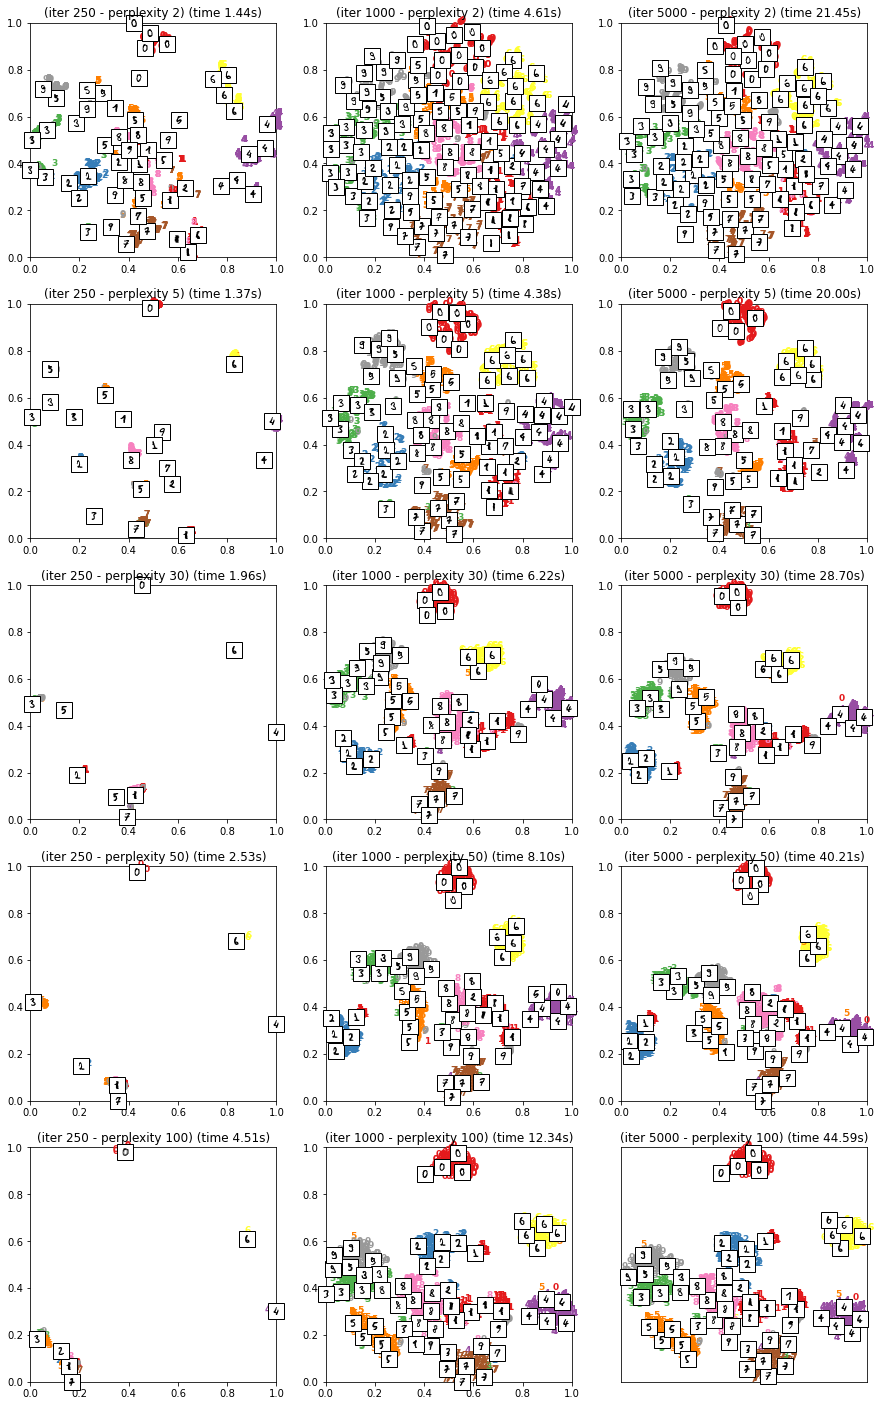

In [15]:
fig, axes = plt.subplots(5, 3, figsize=(15,25))

for i in range(5):
    for j in range(3):
        plot_embedding_MNIST(X_tsne_list[i*3+j], y, digits, tsne_title_list[i*3+j], axes[i][j])

### 3. t-SNE is only suitable for visualing onto 2 or 3 dimension:

The aim of t-SNE is only visualizing high dimensional data into low dimension.  
The authors do not recommend using t-SNE as a dimensional reduction tool for number of dimension over 3.

In [16]:
tsne_3d = manifold.TSNE(n_components=3, init='pca', perplexity=n_neighbors, method='barnes_hut', random_state=0)
X_tsne_3d = tsne_3d.fit_transform(X)
fig = px.scatter_3d(
    pd.DataFrame(data={'X1': X_tsne_3d[:, 0], 'X2': X_tsne_3d[:, 1], 'X3': X_tsne_3d[:, 2], 'y': y}), 
    x='X1', y='X2', z='X3',
    color='y')
fig.show()

One further notice, since t-SNE uses conditional probability to measure similarity.  
The distance, over a certain threshold, won't hold any meaning anymore.   
In other word, we can only say that datapoints that is close to each other is similar. But the distant between clusters does not mean that a cluster is more similar to another than any other.

### 4. t-SNE is not a dimensional reduction preprocessing tool:  

We want to stress again that t-SNE purpose is only for visualization.  
To demonstrade, we will try to apply t-SNE as a preprocessing tool before clustering or prediction.

In [17]:
# t-SNE as input to clustering
perplexity = 30
n_iter = 1000
tsne = manifold.TSNE(n_components=2, init='pca', perplexity=perplexity, n_iter=n_iter, method='barnes_hut', random_state=0)
X_tsne = tsne.fit_transform(X)

kmeans_10 = KMeans(n_clusters=10, random_state=0).fit(X_tsne)
y_kmeans_10 = kmeans_10.labels_

kmeans_12 = KMeans(n_clusters=12, random_state=0).fit(X_tsne)
y_kmeans_12 = kmeans_12.labels_

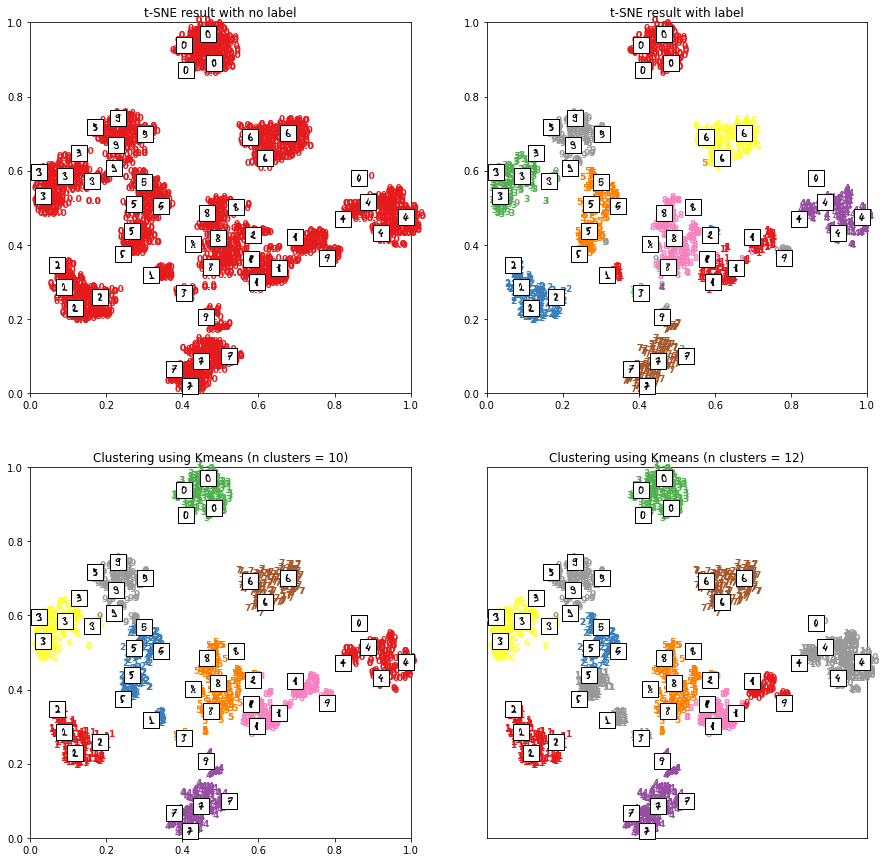

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(15,15))
plot_embedding_MNIST(X_tsne, np.zeros(len(X_tsne)), digits, 't-SNE result with no label', axes[0][0])
plot_embedding_MNIST(X_tsne, y, digits, 't-SNE result with label', axes[0][1])
plot_embedding_MNIST(X_tsne, y_kmeans_10, digits, 'Clustering using Kmeans (n clusters = 10)', axes[1][0])
plot_embedding_MNIST(X_tsne, y_kmeans_12, digits, 'Clustering using Kmeans (n clusters = 12)', axes[1][1])

We can see some incorrect clusters.  
The reason is clustering algorithms like kmeans measure similarity by distance. While t-SNE does not preserve the distance when reducing dimension.

In [19]:
# t-SNE as input to prediction
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

tsne = manifold.TSNE(n_components=2, init='pca', perplexity=n_neighbors, method='barnes_hut', random_state=0)
X_tsne_train = tsne.fit_transform(X_train)
X_tsne_test = tsne.fit_transform(X_test)

y_dt = DecisionTreeClassifier().fit(X_train, y_train).predict(X_test)
y_dt_tsne = DecisionTreeClassifier().fit(X_tsne_train, y_train).predict(X_tsne_test)

y_knn = KNeighborsClassifier().fit(X_train, y_train).predict(X_test)
y_knn_tsne = KNeighborsClassifier().fit(X_tsne_train, y_train).predict(X_tsne_test)

y_mlp = MLPClassifier(random_state=0).fit(X_train, y_train).predict(X_test)
y_mlp_tsne = MLPClassifier(random_state=0).fit(X_tsne_train, y_train).predict(X_tsne_test)

c:\users\ltt610\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



In [20]:
scores = []

def calculate_scores(y_true, y_pred, method_name):
    return [
        method_name, 
        accuracy_score(y_true, y_pred),
        precision_score(y_true, y_pred, average='micro'),
        recall_score(y_true, y_pred, average='micro'),
        f1_score(y_true, y_pred, average='micro')
    ]
    
scores.append(calculate_scores(y_test, y_dt, 'Decision Tree'))
scores.append(calculate_scores(y_test, y_dt_tsne, 'Decision Tree with t-SNE'))
scores.append(calculate_scores(y_test, y_knn, 'KNNs'))
scores.append(calculate_scores(y_test, y_knn_tsne, 'KNNs with t-SNE'))
scores.append(calculate_scores(y_test, y_mlp, 'Neural Network'))
scores.append(calculate_scores(y_test, y_mlp_tsne, 'Neural Network with t-SNE'))

scores = pd.DataFrame(data=scores)
scores.columns = ['Method', 'Accuracy', 'Precision', 'Recall', 'F1']
print(scores)

                      Method  Accuracy  Precision    Recall        F1
0              Decision Tree  0.827778   0.827778  0.827778  0.827778
1   Decision Tree with t-SNE  0.048148   0.048148  0.048148  0.048148
2                       KNNs  0.981481   0.981481  0.981481  0.981481
3            KNNs with t-SNE  0.112963   0.112963  0.112963  0.112963
4             Neural Network  0.974074   0.974074  0.974074  0.974074
5  Neural Network with t-SNE  0.038889   0.038889  0.038889  0.038889


The reason for this significant drop in scores is because:  
- t-SNE is non-parametric  
- t-SNE is non-deterministic  

So the structure of train and test set won't be the same in low dimension. 

## III. Where else to use t-SNE: